In [80]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

pd.options.display.max_columns = 120


In [81]:
def load_data(file_path):
    """Load data from a CSV file into a pandas DataFrame."""
    return pd.read_csv(file_path)

In [82]:
train_dir = Path("../data_sync/outputs/Training_and_validation_set/NR")
train_files = list(train_dir.glob("*.csv"))
print(f"Training files: {len(train_files)}")

test_dir = Path("../data_sync/outputs/Test_set/NR")
test_files = list(test_dir.glob("*.csv"))
print(f"Test files: {len(test_files)}")     

Training files: 10
Test files: 2


In [83]:
# Parameters regarding how far back in time to feed
history = 10
lag = 5
output_col = "Gear"

In [84]:
info_columns = ['tt_s', 'Lap', 'Gear', 'ns1:LatitudeDegrees', 'ns1:LongitudeDegrees', 'Sport'] 
feature_columns_pole_data = ['speed_kmph', 'power_w', 'frequency_ppm', 'thrust_left_ms', 'thrust_right_ms', 'impulse_left_ns', 'impulse_right_ns', 'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n']
feature_columns_gnss = ['ns1:AltitudeMeters', 'ns2:Speed', 'ns2:RunCadence', 'ns2:Watts']

In [85]:
dfs = [load_data(file) for file in train_files]
test_dfs = [load_data(file) for file in test_files]

def make_sure_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

dfs = [make_sure_numeric(df, feature_columns_gnss + feature_columns_pole_data) for df in dfs]
test_dfs = [make_sure_numeric(df, feature_columns_gnss + feature_columns_pole_data) for df in test_dfs]

In [86]:
def add_ratios(df):
    df = df.copy()
    df["force_ratio"] = df["force_meanl_n"]/(df["force_meanl_n"] + df["force_meanr_n"] + 1e-6)
    df["thrust_ratio"] = df["thrust_left_ms"]/(df["thrust_left_ms"] + df["thrust_right_ms"] + 1e-6)
    df["impulse_ratio"] = df["impulse_left_ns"]/(df["impulse_left_ns"] + df["impulse_right_ns"] + 1e-6)
    return df

dfs = [add_ratios(df) for df in dfs]
test_dfs = [add_ratios(df) for df in test_dfs]
feature_columns = feature_columns_pole_data + feature_columns_gnss + ["force_ratio", "thrust_ratio", "impulse_ratio"]

In [87]:
def create_lagged_features(df, feature_columns, history, lag):
    df = df.copy()
    for h in range(1, lag + 1):
        for col in feature_columns:
            df[f"{col}_lag{h}"] = df[col].shift(h)
    for h in range(history):
        for col in feature_columns:
            df[f"{col}_mean"] = df[col].shift(h).rolling(window=lag).mean()
            df[f"{col}_std"] = df[col].shift(h).rolling(window=lag).std()
    df = df.dropna().reset_index(drop=True)
    return df

dfs = [create_lagged_features(df, feature_columns, history, lag) for df in dfs]
test_dfs = [create_lagged_features(df, feature_columns, history, lag) for df in test_dfs]

feature_columns_lagged = []
for h in range(1, lag + 1):
    for col in feature_columns:
        feature_columns_lagged.append(f"{col}_lag{h}")
for col in feature_columns:
        feature_columns_lagged.append(f"{col}_mean")
        feature_columns_lagged.append(f"{col}_std")
feature_columns = feature_columns + feature_columns_lagged


/var/folders/js/3kl4pzld50qdxyxznqpfnbz00000gn/T/ipykernel_57709/133474891.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_mean"] = df[col].shift(h).rolling(window=lag).mean()
/var/folders/js/3kl4pzld50qdxyxznqpfnbz00000gn/T/ipykernel_57709/133474891.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_std"] = df[col].shift(h).rolling(window=lag).std()
/var/folders/js/3kl4pzld50qdxyxznqpfnbz00000gn/T/ipykernel_57709/133474891.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the 

In [88]:
def add_acceleration(df):
    df = df.copy()
    df['acceleration'] = df['ns2:Speed'].diff()
    df['acceleration'].fillna(0, inplace=True)
    return df
dfs = [add_acceleration(df) for df in dfs]
test_dfs = [add_acceleration(df) for df in test_dfs]
feature_columns.append('acceleration')

/var/folders/js/3kl4pzld50qdxyxznqpfnbz00000gn/T/ipykernel_57709/1663801313.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['acceleration'].fillna(0, inplace=True)
/var/folders/js/3kl4pzld50qdxyxznqpfnbz00000gn/T/ipykernel_57709/1663801313.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

In [89]:
train_df = pd.concat(dfs, ignore_index=True)
print(f"Training data shape: {train_df.shape}")
test_df = pd.concat(test_dfs, ignore_index=True)
print(f"Test data shape: {test_df.shape}")

Training data shape: (11141, 143)
Test data shape: (2393, 143)


In [90]:
def XY(df):
    X = df[feature_columns]
    Y = df[output_col]
    return X, Y

In [91]:
X_train, y_train = XY(train_df)
X_test, y_test = XY(test_df)

Training tuned Random Forest...
Out-of-bag score: 0.9157

TUNED MODEL - Training Performance
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97      2247
        2.0H       0.95      1.00      0.97      1103
        2.0V       0.98      1.00      0.99       548
         3.0       1.00      0.97      0.99      5772
         4.0       0.94      0.99      0.96      1471

    accuracy                           0.98     11141
   macro avg       0.97      0.99      0.98     11141
weighted avg       0.98      0.98      0.98     11141



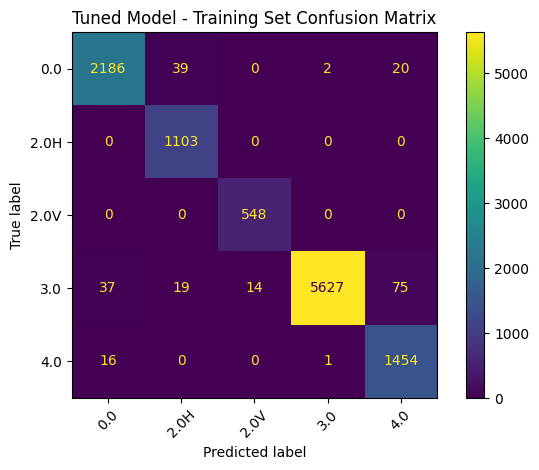


TUNED MODEL - Test Performance
              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93       391
        2.0H       0.93      1.00      0.96       190
        2.0V       0.99      0.86      0.92       170
         3.0       0.94      0.90      0.92      1414
         4.0       0.53      0.61      0.56       228

    accuracy                           0.89      2393
   macro avg       0.85      0.87      0.86      2393
weighted avg       0.90      0.89      0.89      2393



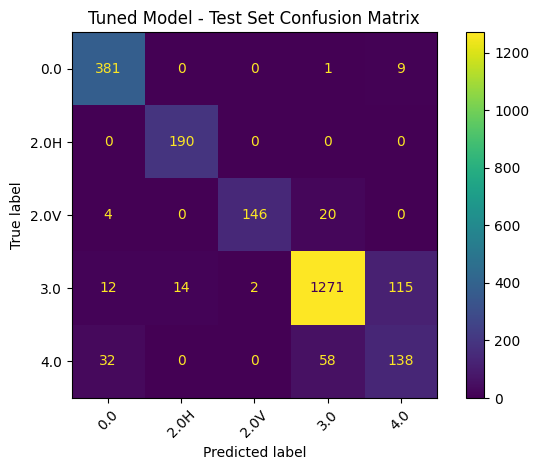

In [92]:
rf_tuned = RandomForestClassifier(
    n_estimators=200,              # Tress
    max_depth=15,                  # Tree depth
    min_samples_split=10,          # Samples needed for a split
    min_samples_leaf=4,            # Samples needed for a leaf
    max_features='sqrt',           # Use sqrt(n_features) per split (adds randomness)
    class_weight='balanced',       # Keep this for class imbalance
    bootstrap=True,                # Enable bootstrapping
    oob_score=True,                # Get out-of-bag score (free validation estimate)
    n_jobs=-1,
    random_state=42
)

print("Training tuned Random Forest...")
rf_tuned.fit(X_train, y_train)
print(f"Out-of-bag score: {rf_tuned.oob_score_:.4f}")

pred_train = rf_tuned.predict(X_train)
pred_test = rf_tuned.predict(X_test)

print("\n" + "="*50)
print("TUNED MODEL - Training Performance")
print("="*50)
print(classification_report(y_train, pred_train))


# Confusion matrix
cm = confusion_matrix(y_train, pred_train, labels=sorted(y_train.unique()))
ConfusionMatrixDisplay(cm, display_labels=sorted(y_train.unique())).plot(xticks_rotation=45)
plt.title("Tuned Model - Training Set Confusion Matrix")
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("TUNED MODEL - Test Performance")
print("="*50)
print(classification_report(y_test, pred_test))

# Confusion matrix
cm = confusion_matrix(y_test, pred_test, labels=sorted(y_train.unique()))
ConfusionMatrixDisplay(cm, display_labels=sorted(y_train.unique())).plot(xticks_rotation=45)
plt.title("Tuned Model - Test Set Confusion Matrix")
plt.tight_layout()
plt.show()


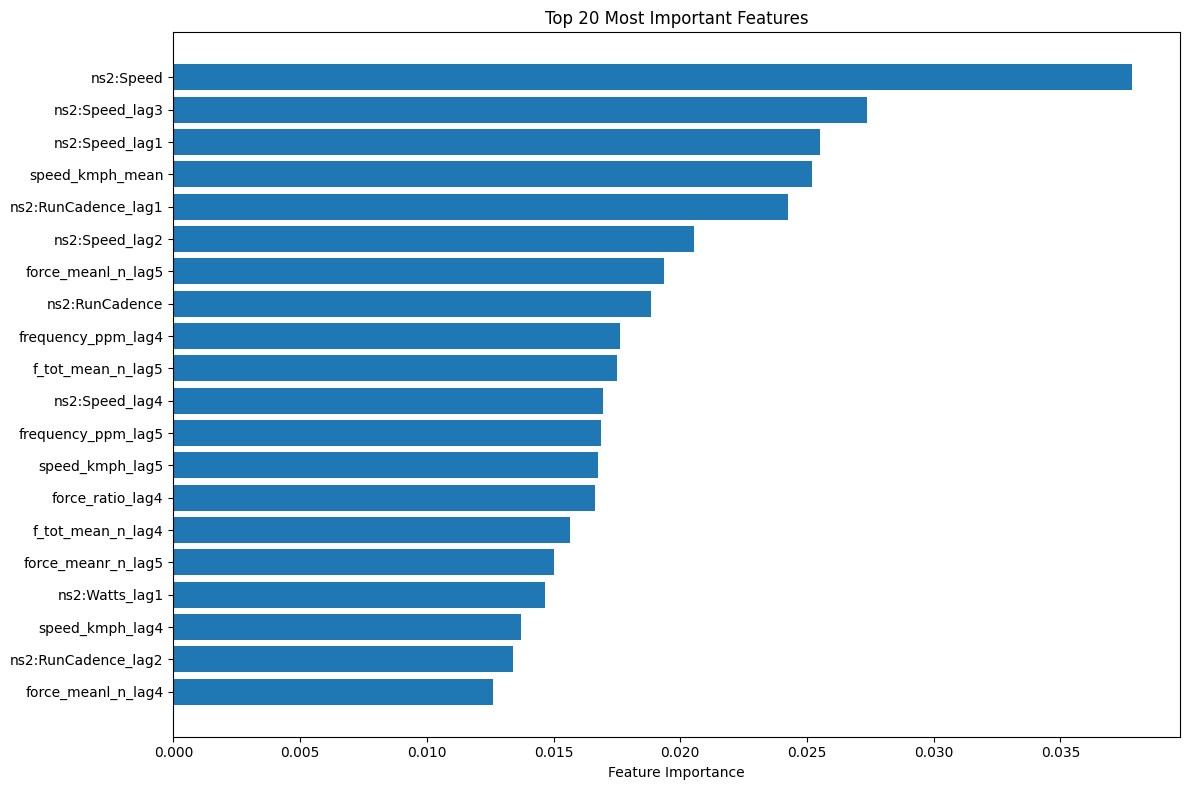


Top 10 most important features:
                 feature  importance
11             ns2:Speed    0.037825
62        ns2:Speed_lag3    0.027368
28        ns2:Speed_lag1    0.025499
102      speed_kmph_mean    0.025197
29   ns2:RunCadence_lag1    0.024236
45        ns2:Speed_lag2    0.020537
92    force_meanl_n_lag5    0.019373
12        ns2:RunCadence    0.018842
70    frequency_ppm_lag4    0.017625
94     f_tot_mean_n_lag5    0.017486


In [93]:
# Analyze feature importance to understand what drives predictions
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_tuned.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(feature_importance.head(10))

MLP — Test
              precision    recall  f1-score   support

         0.0       0.76      0.92      0.83       391
        2.0H       0.92      0.96      0.94       190
        2.0V       0.97      0.88      0.92       170
         3.0       0.93      0.87      0.90      1414
         4.0       0.55      0.57      0.56       228

    accuracy                           0.86      2393
   macro avg       0.83      0.84      0.83      2393
weighted avg       0.87      0.86      0.86      2393



/Users/gustafbjorn/Documents/Chalmers/CAS/TRA300 Digitalization in sports/Project/Project/tra300-ski-technique-classification/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


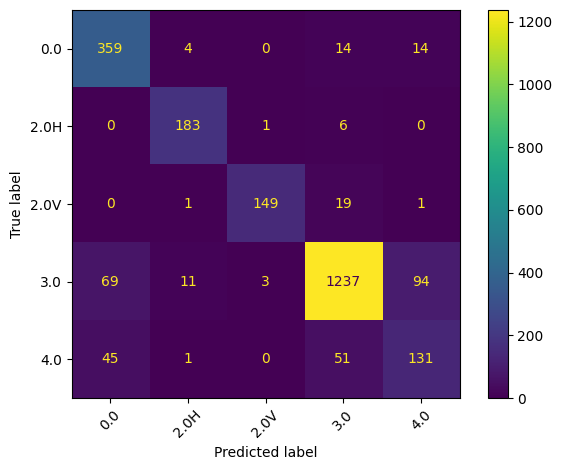

MLP — Train
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96      2247
        2.0H       0.96      0.98      0.97      1103
        2.0V       0.98      0.94      0.96       548
         3.0       0.98      0.98      0.98      5772
         4.0       0.96      0.97      0.96      1471

    accuracy                           0.97     11141
   macro avg       0.97      0.96      0.97     11141
weighted avg       0.97      0.97      0.97     11141



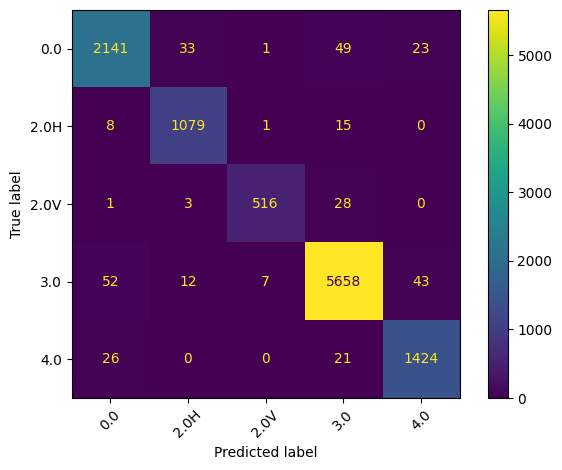

In [94]:
mlp = MLPClassifier(
    hidden_layer_sizes=(128,64), activation="relu",
    batch_size=256, max_iter=50, learning_rate="adaptive",
    random_state=42
)
mlp.fit(X_train, y_train)
pred_test_mlp = mlp.predict(X_test)
pred_train_mlp = mlp.predict(X_train)
print("MLP — Test")
print(classification_report(y_test, pred_test_mlp))

cm = confusion_matrix(y_test, pred_test_mlp, labels=sorted(y_train.unique()))
ConfusionMatrixDisplay(cm, display_labels=sorted(y_train.unique())).plot(xticks_rotation=45)
plt.tight_layout(); plt.show()

print("MLP — Train")
print(classification_report(y_train, pred_train_mlp))

cm = confusion_matrix(y_train, pred_train_mlp, labels=sorted(y_train.unique()))
ConfusionMatrixDisplay(cm, display_labels=sorted(y_train.unique())).plot(xticks_rotation=45)
plt.tight_layout(); plt.show()